In [1]:
using JLD2, FileIO
using Quaternions
using LinearAlgebra
using Statistics
using PyPlot
using MLDatasets
using ImageCore
using Random
using ProgressMeter
include("QRPNN.jl")
rng = MersenneTwister(1234);

In [2]:
# load full training set
train_x, train_y = CIFAR10.traindata();

In [3]:
# Parameters;
params = 40.0;
it_max = 1.e3;

realf = QRPNN.exponential;

Change the realf function to perform the computational experiments with other QRCNNs and QRPNNs.

In [4]:
Smax = 10
P = 200
N = 32*32
tau = 1.e-4

NoiseValues = range(0,stop=0.5,length=21)
Nnoise = length(NoiseValues)
PrRecall_Exp = zeros(Int64,(2,Nnoise))

ExpInput = zeros(Smax,Nnoise)
ExpQRCNN = zeros(Smax,Nnoise)
ExpQRPNN = zeros(Smax,Nnoise)

@showprogress for s = 1:Smax
    # Generate the fundamental memories
    indFM = randperm(rng, size(train_x)[4])[1:P]
    U = Array{Quaternion}(undef,N,P)
    for i=1:P
        U[:,i] = QRPNN.CIFAR2Quat(train_x[:,:,:,indFM[i]])[:]
    end

    # Train the projection model
    V = QRPNN.train(realf,params,U)
        
    for i = 1:Nnoise
        # Generate a corrupted version of a fundamental memory
        img_x = QRPNN.imnoise(train_x[:,:,:,indFM[1]],NoiseValues[i])
        x = QRPNN.CIFAR2Quat(img_x)[:]
        ExpInput[s,i] = norm(U[:,1]-x)
               
        #
        # QRCNN
        #
        y = QRPNN.main(realf,params, U, U, x, it_max)
        PrRecall_Exp[1,i] = PrRecall_Exp[1,i]+(norm(U[:,1]-y)<tau)
        ExpQRCNN[s,i] = norm(U[:,1]-y)
        
        #
        # QRPNN
        #
        y = QRPNN.main(realf,params, U, V, x, it_max)
        PrRecall_Exp[2,i] = PrRecall_Exp[2,i]+(norm(U[:,1]-y)<tau)
        ExpQRPNN[s,i] = norm(U[:,1]-y)
    end
    @save "JLDs/ExpCIFAR_Exponential.jld2" NoiseValues PrRecall_Exp Smax s
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:09


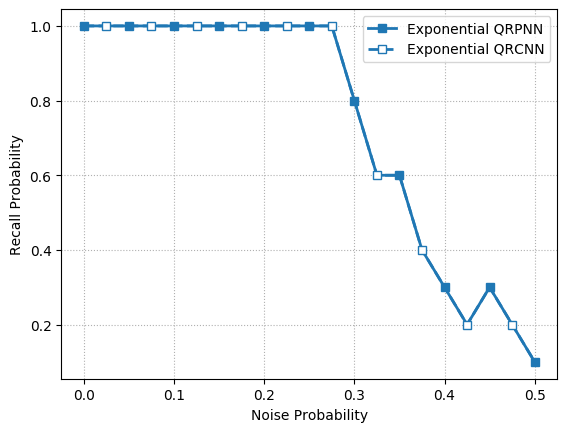

PyObject <matplotlib.legend.Legend object at 0x7fd9d0bc3630>

In [5]:
@load "JLDs/ExpCIFAR_Exponential.jld2"
plot(NoiseValues,PrRecall_Exp[2,:]/Smax,color="#1f77b4",linewidth=2,marker="s",markevery=(0,2),label="Exponential QRPNN")
plot(NoiseValues,PrRecall_Exp[1,:]/Smax,color="#1f77b4",linewidth=2,marker="s",markevery=(1,2),mfc="white",linestyle="dashed",label="Exponential QRCNN")
grid(linestyle="dotted")
xlabel("Noise Probability")
ylabel("Recall Probability")
legend()